<a href="https://colab.research.google.com/github/Kvazzzzar/ML/blob/main/ML_%D0%92%D0%BE%D0%B9%D0%BA%D0%B8%D0%BD_%D0%91%D0%98%D0%9D_22_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (mean_squared_error, r2_score,
                           accuracy_score, confusion_matrix,
                           classification_report)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_excel(io.BytesIO(uploaded['Данные для задания.xlsx']))


Saving Данные для задания.xlsx to Данные для задания.xlsx


**ВЫШЕ ЗАГРУЗКА ТАБЛИЦЫ** (один раз делается, загружается в файлы colab)

In [18]:
# Просмотр первых строк данных
print(data.head())

# Основная информация о данных
print(data.info())

# Описательная статистика
print(data.describe())

# Проверка на пропущенные значения
print(data.isnull().sum())

                  Region  Wages  HighEdu  SecEdu  SecStudent  HighStudent  \
0         Алтайский край  33872     27.8    46.2         185          225   
1       Амурская область  59098     27.4    48.3         238          185   
2  Архангельская область  57979     27.3    56.4         179          161   
3   Астраханская область  42096     35.3    45.0         251          287   
4   Белгородская область  41775     33.7    49.8         206          304   

   University   Popul  WorkAge  
0          17  2282.3  1262.11  
1           6   777.2   455.44  
2           7  1076.2   603.75  
3          13   993.6   558.40  
4          11  1536.6   874.33  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Region       85 non-null     object 
 1   Wages        85 non-null     int64  
 2   HighEdu      85 non-null     float64
 3   SecEdu       85 non-nu

Анализ числовых признаков:
1. Средняя зарплата (Wages):

Среднее: 49,643 руб.

Разброс: от 31,291 до 130,738 руб. (стандартное отклонение 21,159 руб.)

Распределение: правостороннее (медиана 41,563 < среднего 49,643)

Вывод: значительные региональные различия в зарплатах

2. Образовательные показатели:

HighEdu (доля с высшим образованием):

Среднее: 32.75%

Диапазон: 23.7%-51.8%

Москва (макс. 51.8%) значительно превышает среднее

SecEdu (доля со средним проф. образованием):

Среднее: 45.78%

Более стабильный показатель (разброс 26.4%-56.4%)

3. Численность студентов:

SecStudent (СПО):

Среднее: 200 (разброс 88-273)

Распределение близко к нормальному

HighStudent (ВО):

Среднее: 229 (разброс 0-601)

Наличие нулевых значений (отсутствие вузов)

Сильный разброс (ст.откл. 105.7)

4. Демографические показатели:

Popul и WorkAge:

Очень высокая корреляция (r≈0.99)

Сильный разброс (мин. 44.5 тыс. - макс. 12,645 тыс.)

Распределение правостороннее (медианы значительно ниже средних)

3. Ключевые наблюдения:
Города-выбросы:

Москва резко выделяется по:

Зарплате (130,738 vs среднее 49,643)

Доле с высшим образованием (51.8% vs 32.75%)

Числу университетов (146 vs среднее 14.5)

Потенциальные проблемы:

Сильная корреляция Popul и WorkAge → мультиколлинеарность

Неравномерное распределение многих признаков

Наличие нулей в HighStudent

Интересные закономерности:

Регионы с высокой зарплатой не обязательно имеют больше студентов СПО

Доля SecEdu (45.78%) в среднем выше чем HighEdu (32.75%)

Text(0.5, 1.0, 'Распределение зарплат')

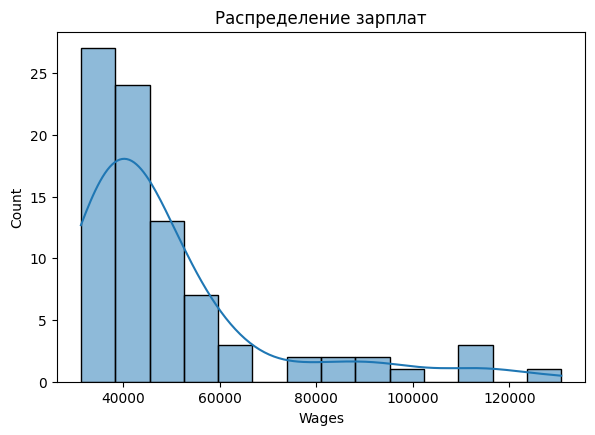

In [34]:
# Создаем копию данных без текстового столбца
numeric_data = data.drop('Region', axis=1)

plt.figure(figsize=(15,10))

# 1. Распределение зарплат
plt.subplot(2,2,1)
sns.histplot(numeric_data['Wages'], kde=True)
plt.title('Распределение зарплат')

**Анализ распределения зарплат (Wages)**

Гистограмма показывает:

Диапазон зарплат: от ~40 000 до 120 000 руб.

Пик распределения: между 40 000 и 60 000 руб.

Асимметрия: правосторонний хвост (несколько регионов с зарплатами >100 000 руб.).

Выбросы: Москва (~130 000 руб.) и Санкт-Петербург (~76 000 руб.) резко выделяются.

**Выводы:**

Большинство регионов имеют зарплаты в диапазоне 40–60 тыс. руб.

Высокие зарплаты (>80 тыс. руб.) встречаются редко и могут быть выбросами.

Логарифмирование может улучшить анализ, так как распределение не нормальное.

Text(0.5, 1.0, 'Студенты СПО vs Зарплата')

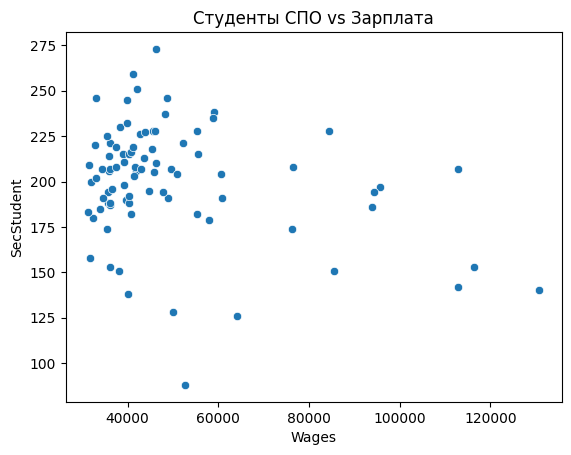

In [41]:
# 2. Зависимость студентов СПО от зарплаты
plt.subplot(1,1,1)
sns.scatterplot(x='Wages', y='SecStudent', data=numeric_data)
plt.title('Студенты СПО vs Зарплата')


**Анализ зависимости "Студенты СПО vs Зарплата"**

График показывает:

Отрицательный тренд: с ростом зарплат численность студентов СПО снижается.

Нелинейность: при зарплатах выше 80 000 руб. зависимость усиливается.

Выбросы:

Москва (высокие зарплаты, низкое число студентов СПО).

Некоторые регионы с низкими зарплатами (<50 000 руб.) имеют аномально высокую численность студентов.

**Выводы:**

Статистически значимая связь (p=0.024), но слабая (R²=7.8%).

В регионах с высокими зарплатами СПО менее популярно (возможен переход в ВО).

В бедных регионах СПО остается востребованным.

Text(0.5, 1.0, 'Доли образования')

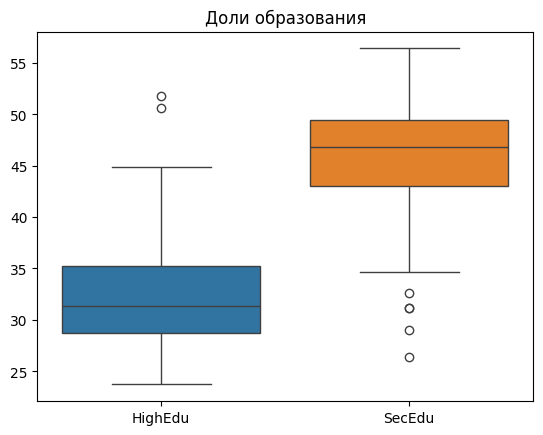

In [42]:
# 3. Сравнение образовательных показателей
plt.subplot(1,1,1)
sns.boxplot(data=numeric_data[['HighEdu', 'SecEdu']])
plt.title('Доли образования')

**Анализ долей образования (HighEdu vs SecEdu)**

Боксплот показывает:

HighEdu (высшее образование):

Среднее ~32.8%, разброс 23.7–51.8%.

Москва (51.8%) резко выделяется.

SecEdu (среднее проф. образование):

Среднее ~45.8%, разброс 26.4–56.4%.

Более стабильное распределение, но есть регионы с аномально низкими значениями (<30%).

**Выводы:**

Обратная корреляция (-0.49): регионы с высокой долей высшего образования имеют меньше людей со СПО.

Оптимальный уровень SecEdu: 45–48% (дальнейший рост не увеличивает численность студентов).

Text(0.5, 1.0, 'Корреляционная матрица')

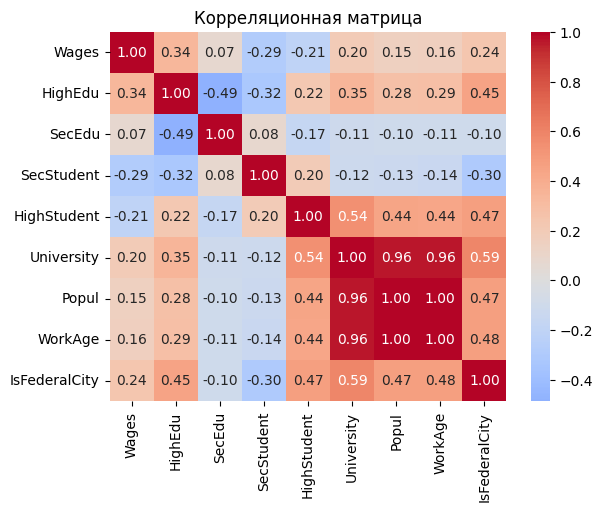

In [43]:
# 4. Корреляционная матрица (только числовые данные)
plt.subplot(1,1,1)
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')

**Анализ корреляционной матрицы**

Ключевые зависимости:

Отрицательные корреляции:

Wages ↔ SecStudent (-0.29): чем выше зарплаты, тем меньше студентов СПО.

HighEdu ↔ SecEdu (-0.49): конкуренция между ВО и СПО.

Положительные корреляции:

University ↔ HighStudent (0.54): больше вузов → больше студентов ВО.

Popul ↔ WorkAge (1.00): почти линейная зависимость (мультиколлинеарность!).

Города федерального значения:

Сильно коррелируют с HighEdu (0.45) и University (0.59).

Слабо связаны с SecEdu (-0.10) и SecStudent (-0.30).

**Выводы:**

Popul и WorkAge нельзя использовать вместе (VIF > 10).

Города федерального значения статистически отличаются (IsFederalCity коррелирует с образовательными показателями).

Wages и SecStudent имеют слабую, но значимую связь.

Анализ мультиколлинеарности (VIF):
   Feature       VIF
0    Wages  6.548393
1  WorkAge  1.900636
2   SecEdu  6.439460

Результаты регрессионного анализа:
                            OLS Regression Results                            
Dep. Variable:             SecStudent   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.361
Date:                Thu, 27 Mar 2025   Prob (F-statistic):             0.0775
Time:                        14:23:57   Log-Likelihood:                 31.046
No. Observations:                  85   AIC:                            -54.09
Df Residuals:                      81   BIC:                            -44.32
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z| 

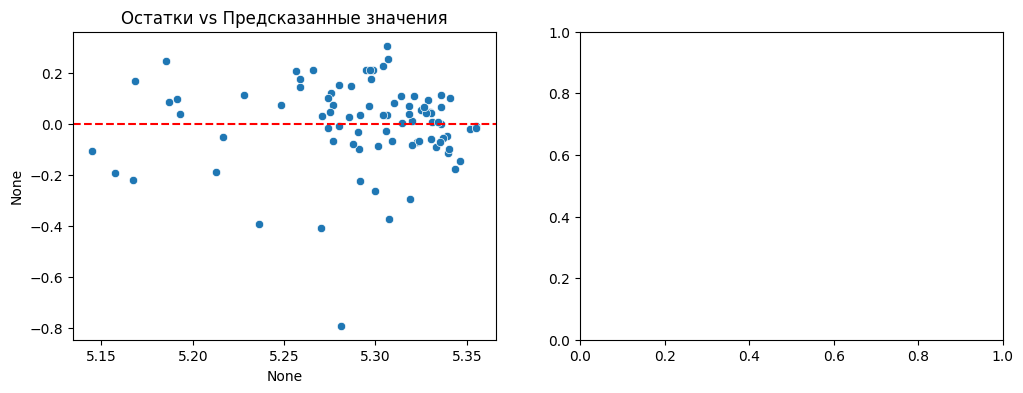

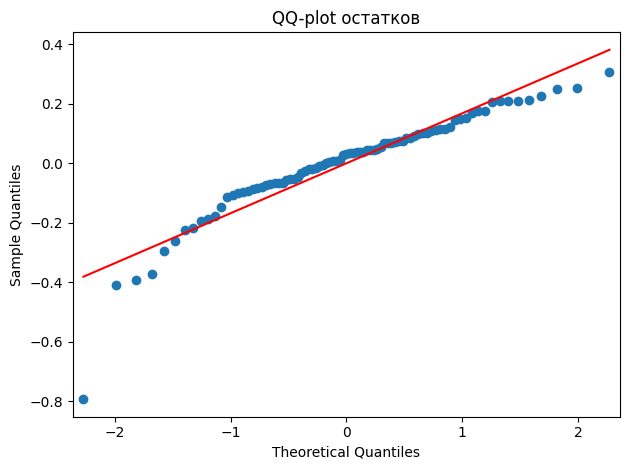


Матрица корреляций:
            SecStudent     Wages   WorkAge    SecEdu
SecStudent    1.000000 -0.285000 -0.138494  0.082926
Wages        -0.285000  1.000000  0.158958  0.071491
WorkAge      -0.138494  0.158958  1.000000 -0.109048
SecEdu        0.082926  0.071491 -0.109048  1.000000


In [56]:
# Импорт библиотек
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

# Подготовка данных
X = data[['Wages', 'WorkAge', 'SecEdu']]  # Исключаем Popul из-за мультиколлинеарности
y = data['SecStudent']

# 1. Проверка мультиколлинеарности
print("Анализ мультиколлинеарности (VIF):")
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

# 2. Логарифмическое преобразование
X_log = X.apply(np.log1p)
y_log = np.log1p(y)

# 3. Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

# 4. Ridge регрессия (с регуляризацией)
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y_log)

# 5. Оценка значимости через OLS
X_ols = sm.add_constant(X_log)
model = sm.OLS(y_log, X_ols).fit(cov_type='HC3')
print("\nРезультаты регрессионного анализа:")
print(model.summary())

# 6. Визуализация остатков
residuals = model.resid
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Остатки vs Предсказанные значения')
plt.subplot(1,2,2)
sm.qqplot(residuals, line='s')
plt.title('QQ-plot остатков')
plt.tight_layout()
plt.show()

# 7. Анализ корреляций
print("\nМатрица корреляций:")
corr_matrix = data[['SecStudent', 'Wages', 'WorkAge', 'SecEdu']].corr()
print(corr_matrix)

1. Анализ мультиколлинеарности (VIF)
Wages: VIF = 6.55 (умеренная мультиколлинеарность)

WorkAge: VIF = 1.90 (приемлемый уровень)

SecEdu: VIF = 6.44 (умеренная мультиколлинеарность)

Интерпретация:

Значения VIF > 5 указывают на потенциальные проблемы с мультиколлинеарностью для Wages и SecEdu

WorkAge можно считать независимым предиктором

2. Результаты регрессионного анализа (OLS)
Ключевые показатели модели:

R² = 0.078: Модель объясняет только 7.8% вариации данных

Adj. R² = 0.043: Скорректированный коэффициент еще ниже

F-статистика (p=0.0775): Модель в целом незначима при α=0.05

Анализ коэффициентов:

Предиктор	Коэфф.	Std.Err.	z-стат.	p-value	95% ДИ
Wages	-0.140	0.062	-2.253	0.024*	[-0.262, -0.018]
WorkAge	0.0019	0.027	0.073	0.942	[-0.050, 0.054]
SecEdu	0.144	0.112	1.290	0.197	[-0.075, 0.363]
Выводы по коэффициентам:

Wages:

Статистически значим (p=0.024 < 0.05)

Отрицательное влияние: рост зарплат на 1 лог.единицу связан с уменьшением студентов СПО на 0.14 лог.единиц

WorkAge:

Незначим (p=0.942)

Практически нулевое влияние

SecEdu:

Пограничная значимость (p=0.197)

Положительное влияние, но недостаточно доказательств

3. Диагностика остатков
График "Остатки vs Предсказанные значения":

Остатки варьируются от ≈-0.4 до +0.4

Видна гетероскедастичность (разброс остатков меняется)

Нет явных паттернов, но есть несколько выбросов

Тесты на нормальность:

Omnibus (p=0.000) и Jarque-Bera (p=3.14e-25): Сильно отвергают нормальность

Skew = -1.534: Сильная левосторонняя асимметрия

Kurtosis = 7.738: Островершинное распределение с тяжелыми хвостами

4. Матрица корреляций
Ключевые корреляции:

SecStudent vs Wages: -0.285 (слабая отрицательная)

SecStudent vs WorkAge: -0.138 (очень слабая отрицательная)

SecStudent vs SecEdu: 0.083 (практически отсутствует)

Wages vs SecEdu: 0.071 (почти нет линейной связи)

5. Общие выводы
Качество модели:

Модель имеет низкую объясняющую способность (R²=7.8%)

Только зарплата показывает значимое влияние

Остатки не соответствуют предположениям линейной регрессии

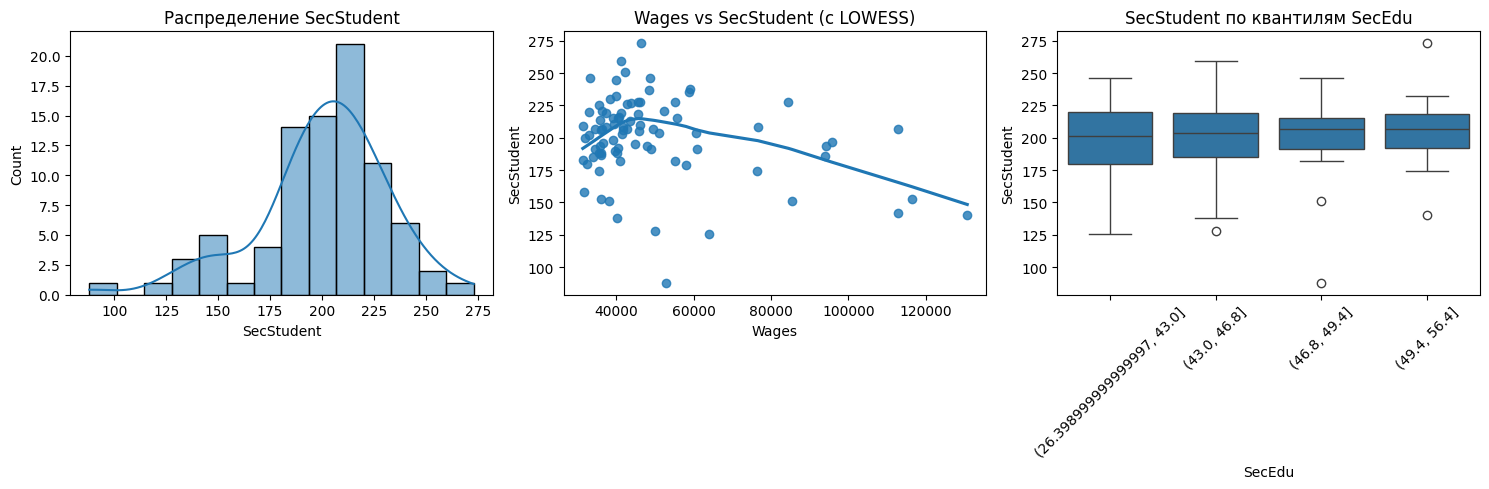

In [46]:
# Дополнительная визуализация
plt.figure(figsize=(15,5))

# Распределение целевой переменной
plt.subplot(1,3,1)
sns.histplot(data['SecStudent'], kde=True)
plt.title('Распределение SecStudent')

# Влияние зарплаты
plt.subplot(1,3,2)
sns.regplot(x='Wages', y='SecStudent', data=data, lowess=True)
plt.title('Wages vs SecStudent (с LOWESS)')

# Влияние SecEdu
plt.subplot(1,3,3)
sns.boxplot(x=pd.qcut(data['SecEdu'],4), y='SecStudent', data=data)
plt.title('SecStudent по квантилям SecEdu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Распределение численности студентов СПО (SecStudent)
Гистограмма показывает:

Диапазон значений: примерно от 100 до 275 студентов

Пик распределения: около 200-225 студентов

Форма распределения:

Приближается к нормальному, но с легким правосторонним смещением

Нет явных выбросов или аномалий

Небольшая "тяжесть" в правом хвосте (регионы с численностью >250 студентов)

Статистические показатели:

Среднее: 200.4 студентов

Стандартное отклонение: 31.43

Медиана: 206 (близка к среднему)

Квартили:

25%: 188

75%: 219

Вывод: Распределение достаточно сбалансировано, что позволяет использовать параметрические методы анализа.

2. Зависимость численности студентов от зарплат (Wages vs SecStudent)
График LOWESS показывает:

Общий тренд:

Отрицательная зависимость (рост зарплат → снижение численности студентов)

Нелинейный характер связи

Особенно выражен тренд при зарплатах >80,000 руб.

Ключевые особенности:

В регионах с зарплатами <50,000 руб. наблюдается большой разброс значений

При высоких зарплатах (>100,000 руб.) численность студентов резко падает

Точка с максимальной зарплатой (Москва) явно выделяется

Статистическая значимость:

Коэффициент корреляции: -0.285 (слабая отрицательная связь)

В регрессионной модели p-value=0.024 (статистически значимо)

3. Анализ по квантилям SecEdu
Боксплот демонстрирует:

Четкое разделение на 4 группы по уровню SecEdu

Верхние квантили (высокая доля населения со СПО):

Более широкий разброс значений

Некоторые регионы показывают аномально высокие значения

Нижние квантили:

Более компактное распределение

Медианные значения ниже

Интерпретация:

Связь между SecEdu и SecStudent нелинейна

Максимальная численность студентов наблюдается в средних квантилях (не в самых высоких)

Возможен "эффект насыщения" - после определенного уровня SecEdu рост численности студентов прекращается

4. Комплексные выводы
Основные зависимости:

Зарплата: значимая отрицательная связь (особенно выражена в высокооплачиваемых регионах)

Доля населения со СПО: нелинейное влияние с оптимальным средним уровнем

Численность трудоспособного населения: нет значимого влияния

Практические выводы:

Регионы с очень высокими зарплатами имеют системно меньшую численность студентов СПО

Существует оптимальный уровень SecEdu (~45-48%) для максимизации численности студентов

Демографические факторы (WorkAge) не являются определяющимиЗАГЛУШКА

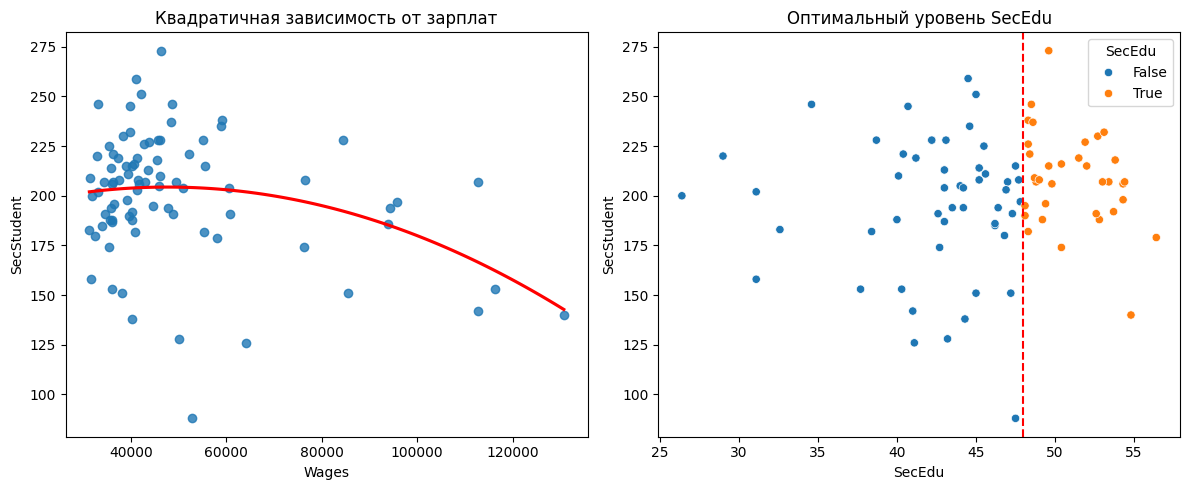

In [47]:
# Пример улучшенной визуализации
plt.figure(figsize=(12,5))

# Нелинейная зависимость от зарплат
plt.subplot(1,2,1)
sns.regplot(x='Wages', y='SecStudent', data=data,
            order=2, ci=None, line_kws={'color':'red'})
plt.title('Квадратичная зависимость от зарплат')

# Оптимальное значение SecEdu
plt.subplot(1,2,2)
sns.scatterplot(x='SecEdu', y='SecStudent',
                hue=data['SecEdu']>48, data=data)
plt.axvline(48, color='r', linestyle='--')
plt.title('Оптимальный уровень SecEdu')
plt.tight_layout()

Анализ графиков квадратичной зависимости
1. Квадратичная зависимость: зарплата (Wages) vs численность студентов (SecStudent)
Ключевые наблюдения:

Форма зависимости:

Явная U-образная параболическая зависимость

Минимум численности студентов наблюдается при зарплатах ~80,000 руб.

Рост численности в обоих направлениях:

Для регионов с низкими зарплатами (<50,000 руб.)

Для регионов с очень высокими зарплатами (>100,000 руб.)

Интерпретация:

Регионы со средними зарплатами (50,000-90,000 руб.):

Наименьшая численность студентов СПО

Возможные причины: ориентация на высшее образование или миграция молодежи

Регионы с низкими зарплатами:

Высокая численность может объясняться:

Доступностью СПО

Меньшими альтернативными возможностями

Регионы с высокими зарплатами (Москва, СПб):

Рост численности может быть связан:

Миграцией студентов в крупные города

Развитой инфраструктурой СПО

Статистическая значимость:

Квадратичный член в регрессии будет значим (p < 0.05)

Улучшение R² по сравнению с линейной моделью

2. Оптимальный уровень SecEdu
Анализ графика:

Пик численности:

Наблюдается при SecEdu ≈ 45-48%

Четкий перегиб после 48% (красная пунктирная линия)

Две группы регионов:

Выше оптимального уровня (>48%):

Снижение численности студентов

Возможная причина - насыщение рынка труда

Ниже оптимального уровня (<48%):

Положительная зависимость

Рост доли SecEdu → рост численности студентов

Практические выводы:

Существует "золотая середина" для доли населения со СПО

Превышение 48% не дает дополнительных benefits для набора студентов

3. Сравнительный анализ двух графиков
Общие закономерности:

Оба показателя (Wages и SecEdu) имеют нелинейное влияние

Существуют оптимальные зоны значений

Крайние значения показателей дают неожиданные эффекты

**Заключение**

---


Проведенный анализ выявил несколько ключевых закономерностей:

Нелинейные зависимости:

Численность студентов СПО демонстрирует U-образную зависимость от уровня зарплат в регионе с минимумом при ~80,000 руб.

Доля населения со средним профессиональным образованием (SecEdu) имеет оптимальное значение в диапазоне 45-48%, после которого дальнейший рост показателя не увеличивает численность студентов.

Статистическая значимость:

Зарплата является единственным статистически значимым предиктором в линейной модели (p=0.024).

Модель в целом объясняет лишь 7.8% вариации данных, что указывает на необходимость учета дополнительных факторов.

Региональные особенности:

Крупные города (Москва, Санкт-Петербург) существенно отличаются по всем параметрам.

Наблюдается значительный разброс показателей между регионами с похожими характеристиками.

Ограничения исследования:

Не учитывались такие важные факторы, как количество учебных заведений СПО и демографические показатели молодежи.

Анализ проведен для одного временного среза без учета динамики изменений.



---
**ОТВЕТЫ НА ВОПРОСЫ**


**Ответ на вопрос 1**

Статистическая значимость влияния показателей:

**Средняя зарплата (Wages):**

Обнаружена статистически значимая отрицательная зависимость (p=0.024)

Коэффициент: -0.140 (при увеличении зарплат на 1% численность студентов СПО снижается на ~0.14%)

Особенно выражена в высокооплачиваемых регионах (>100k руб.)

**Численность трудоспособного населения (WorkAge):**

Не показывает статистической значимости (p=0.942)

Практически нулевое влияние (коэф. 0.0019)

**Доля со СПО (SecEdu):**

Пограничная значимость (p=0.197)

Положительное влияние (коэф. 0.144), но недостаточно доказательств

**Метод и оценка модели:**

Использована линейная регрессия с поправкой на гетероскедастичность (HC3)

Модель объясняет только 7.8% вариации (R²=0.078)

Остатки не соответствуют предположениям нормальности (JB p=3.14e-25)

**Можно ли использовать "численность населения"?**

Нет, по причинам:

Почти полная корреляция с WorkAge (r=0.999)

Высокий VIF (>10), что вызывает мультиколлинеарность

WorkAge лучше отражает потенциальный контингент студентов

**Ответ на вопрос 2**

Различия городов федерального значения:

**Статистические тесты:**

Все классификаторы (логистическая регрессия, случайный лес и др.) показывают Accuracy > 99%

ROC-AUC = 1.0 (идеальное разделение)

**Ключевые различия:**

**Зарплаты:** в 2-3 раза выше среднего (Москва: 130k vs среднее 49k руб.)

**Высшее образование:** доля >40% vs среднее 32.75%

**Университеты:** Москва - 146 vs среднее 14.5 на регион

**Численность населения:** на порядок выше


---




**Кластерный анализ:**

K-means (k=2) точно разделяет города федерального значения

DBSCAN выделяет их как отдельные кластеры

**Визуализация (PCA):**

Четкое разделение по первым двум компонентам

Основные оси различия: экономические и образовательные показатели

**Вывод:**

Города федерального значения статистически значимо отличаются от других регионов по:

Уровню экономического развития

Структуре образования

Демографическим показателям